In [1]:
import pandas as pd
import numpy as np

In [2]:
import torch
from transformers import pipeline
from transformers import AutoTokenizer, ModernBertForSequenceClassification

import torch.nn.functional as F

In [3]:
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
model = ModernBertForSequenceClassification.from_pretrained("answerdotai/ModernBERT-base")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

# To train a model on `num_labels` classes, you can pass `num_labels=num_labels` to `.from_pretrained(...)`
num_labels = len(model.config.id2label)
print(num_labels)
model = ModernBertForSequenceClassification.from_pretrained("answerdotai/ModernBERT-base", num_labels=num_labels)

labels = torch.tensor([1])
loss = model(**inputs, labels=labels).loss
round(loss.item(), 2)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2


1.02

In [4]:
print(model.config.num_hidden_layers)

22


In [5]:
print("\n===== ALL TOP-LEVEL MODULES =====")
for name, module in model.named_children():
    print(name, " --> ", type(module))

print("\n===== FULL MODULE TREE =====")
for name, module in model.named_modules():
    print(name)


===== ALL TOP-LEVEL MODULES =====
model  -->  <class 'transformers.models.modernbert.modeling_modernbert.ModernBertModel'>
head  -->  <class 'transformers.models.modernbert.modeling_modernbert.ModernBertPredictionHead'>
drop  -->  <class 'torch.nn.modules.dropout.Dropout'>
classifier  -->  <class 'torch.nn.modules.linear.Linear'>

===== FULL MODULE TREE =====

model
model.embeddings
model.embeddings.tok_embeddings
model.embeddings.norm
model.embeddings.drop
model.layers
model.layers.0
model.layers.0.attn_norm
model.layers.0.attn
model.layers.0.attn.Wqkv
model.layers.0.attn.rotary_emb
model.layers.0.attn.Wo
model.layers.0.attn.out_drop
model.layers.0.mlp_norm
model.layers.0.mlp
model.layers.0.mlp.Wi
model.layers.0.mlp.act
model.layers.0.mlp.drop
model.layers.0.mlp.Wo
model.layers.1
model.layers.1.attn_norm
model.layers.1.attn
model.layers.1.attn.Wqkv
model.layers.1.attn.rotary_emb
model.layers.1.attn.Wo
model.layers.1.attn.out_drop
model.layers.1.mlp_norm
model.layers.1.mlp
model.layer

In [6]:
########

In [7]:
import torch
import torch.nn.functional as F
from transformers import ModernBertForSequenceClassification, AutoTokenizer


class ModernBERTEarlyExitClassifier:
    def __init__(
        self,
        model_name="answerdotai/ModernBERT-base",
        exit_layers=[5, 10, 15, 20],
        threshold=0.90
    ):
        self.device = "cpu"

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Must load with num_labels or HF warns
        self.model = ModernBertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=2
        )
        self.model.to(self.device)
        self.model.eval()

        # Extract structure
        self.embeddings = self.model.model.embeddings
        self.layers = self.model.model.layers
        self.final_norm = self.model.model.final_norm
        self.classifier = self.model.classifier

        self.exit_layers = sorted(exit_layers)
        self.threshold = threshold
        self.num_layers = len(self.layers)

    @torch.no_grad()
    def classify(self, text, dataset_name=None):
    
        enc = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=False
        )
    
        input_ids = enc["input_ids"].to(self.device)
    
        # FIX 1: Convert attention mask → bool
        attention_mask = (enc["attention_mask"] == 1).to(self.device)
    
        # FIX 2: ModernBERT requires position_ids
        position_ids = torch.arange(
            0, input_ids.size(1), dtype=torch.long, device=self.device
        ).unsqueeze(0)
    
        # 1. Embeddings
        hidden = self.embeddings(input_ids)
    
        # 2. Manual transformer block forward
        for i, layer in enumerate(self.layers):
    
            hidden = layer(
                hidden_states=hidden,
                attention_mask=attention_mask,
                position_ids=position_ids,
            )[0]
    
            if i in self.exit_layers:
                cls = hidden[:, 0, :]
                logits = self.classifier(cls)
    
                probs = F.softmax(logits, dim=-1)[0]
                conf, pred = torch.max(probs, dim=0)
    
                if conf.item() >= self.threshold:
                    return pred.item(), i + 1, conf.item()
    
        # 3. Final forward
        hidden = self.final_norm(hidden)
        cls = hidden[:, 0, :]
        logits = self.classifier(cls)
    
        probs = F.softmax(logits, dim=-1)[0]
        conf, pred = torch.max(probs, dim=0)
    
        return pred.item(), self.num_layers, conf.item()

In [8]:
class ModernBERTBaselineClassifier:
    def __init__(self, model_name="answerdotai/ModernBERT-base"):
        # Detect device: MPS (Apple Silicon) → else CPU
        self.device = "cpu"

        # Load tokenizer + classification model
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = ModernBertForSequenceClassification.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()

        # ModernBERT layer count (22 for base)
        self.num_layers = self.model.config.num_hidden_layers

    @torch.no_grad()
    def classify(self, text, dataset_name=None):
        # Tokenize
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=False
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Forward pass
        outputs = self.model(**inputs)
        logits = outputs.logits  # [1, num_labels]

        # Softmax for confidence
        probs = F.softmax(logits, dim=-1)[0]
        conf, pred = torch.max(probs, dim=0)

        return pred.item(), (self.num_layers), conf.item()

In [9]:
import time
import numpy as np

from evaluation.dataset_loaders.sst2 import load_sst2
from evaluation.dataset_loaders.agnews import load_agnews
from evaluation.dataset_loaders.amazon import load_amazon_polarity
from evaluation.dataset_loaders.imdb import load_imdb
from evaluation.dataset_loaders.dbpedia import load_dbpedia
from evaluation.dataset_loaders.yanswers import load_yahoo

dataset_loaders = [
    ("sst2", load_sst2, "classification"),
    ("imdb", load_imdb, "classification"),
    ("amazon_polarity", load_amazon_polarity, "classification")
]

cached_datasets = {}
print("Loading datasets once...\n")

for name, loader, task in dataset_loaders:
    print(f"Loading {name}...")
    cached_datasets[name] = {
        "data": loader(number=500),
        "task": task
    }

print("\nAll datasets loaded.\n")

Loading datasets once...

Loading sst2...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading imdb...
Loading amazon_polarity...

All datasets loaded.



In [10]:
# Extract (text, label) from any format
def extract_text_label(sample):
    if isinstance(sample, dict):
        if "text" in sample:
            return sample["text"], sample["label"]
        elif "sentence" in sample:
            return sample["sentence"], sample["label"]
        elif "input_text" in sample:
            return sample["input_text"], sample["label"]
        else:
            raise ValueError("Unknown dict format:", sample)

    if isinstance(sample, (tuple, list)):
        return sample[0], sample[1]

    raise ValueError("Unknown sample format:", sample)

# Evaluation
def evaluate_dataset(model, dataset, dataset_name):
    correct = 0
    total = 0
    layers_used = []
    total_tokens = 0

    start = time.time()

    for sample in dataset:
        text, label = extract_text_label(sample)

        pred, layer, conf = model.classify(text, dataset_name)

        correct += (pred == label)
        total += 1
        layers_used.append(layer)

        total_tokens += len(model.tokenizer(text)["input_ids"])

    end = time.time()
    latency = (end - start) / total

    return {
        "metric": "accuracy",
        "score": correct / total,
        "avg_latency_sec": latency,
        "tokens_per_sec": total_tokens / (end - start),
        "avg_layers_used": float(np.mean(layers_used)),
        "num_samples": total
    }

In [11]:
results_table = []

print("Running BASELINE")

baseline_model = ModernBERTBaselineClassifier()

for name, meta in cached_datasets.items():
    dataset = meta["data"]
    print(f"\nTesting BASELINE on {name}...")

    result = evaluate_dataset(baseline_model, dataset, name)
    print(name, result)

    results_table.append({
        "dataset": name,
        "threshold": None,
        "mode": "baseline",
        "metric": result["metric"],
        "score": float(result["score"]),
        "avg_latency_sec": float(result["avg_latency_sec"]),
        "tokens_per_sec": float(result["tokens_per_sec"]),
        "avg_layers_used": float(result["avg_layers_used"]),
        "num_samples": int(result["num_samples"]),
    })

Running BASELINE


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing BASELINE on sst2...
sst2 {'metric': 'accuracy', 'score': 0.492, 'avg_latency_sec': 0.026382407665252686, 'tokens_per_sec': 986.642323561817, 'avg_layers_used': 21.0, 'num_samples': 500}

Testing BASELINE on imdb...
imdb {'metric': 'accuracy', 'score': 0.472, 'avg_latency_sec': 0.10874932050704957, 'tokens_per_sec': 2660.356852356109, 'avg_layers_used': 21.0, 'num_samples': 500}

Testing BASELINE on amazon_polarity...
amazon_polarity {'metric': 'accuracy', 'score': 0.506, 'avg_latency_sec': 0.04536823606491089, 'tokens_per_sec': 2130.036527356661, 'avg_layers_used': 21.0, 'num_samples': 500}


In [12]:
# -------------------------
# EARLY EXIT NEXT
# -------------------------
exit_layer_groups = [
    [2, 4, 6, 8, 10],
    [4, 8],
    [3, 6, 9],
    [6]
]

thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for exit_layers in exit_layer_groups:

    print("\n=================================================")
    print(f"Testing EXIT LAYERS: {exit_layers}")
    print("=================================================")

    for th in thresholds:

        print(f"\n----------------------------")
        print(f"Threshold = {th}")
        print(f"Exit Layers = {exit_layers}")
        print("----------------------------")

        # Create modernbert early exit model
        model = ModernBERTEarlyExitClassifier(
            model_name="answerdotai/ModernBERT-base",
            exit_layers=exit_layers,
            threshold=th
        )

        # Evaluate across datasets
        for name, meta in cached_datasets.items():
            dataset = meta["data"]

            print(f"\nTesting {name} (exit_layers={exit_layers}, threshold={th})...")

            result = evaluate_dataset(model, dataset, name)
            print(name, result)

            # Save results with exit_layers column added
            results_table.append({
                "dataset": name,
                "threshold": th,
                "exit_layers": str(exit_layers),       # <<< NEW COLUMN
                "mode": "early_exit",
                "metric": result["metric"],
                "score": float(result["score"]),
                "tokens_per_sec": float(result["tokens_per_sec"]),
                "avg_latency_sec": float(result["avg_latency_sec"]),
                "avg_layers_used": float(result["avg_layers_used"]),
                "num_samples": int(result["num_samples"]),
            })


Testing EXIT LAYERS: [2, 4, 6, 8, 10]

----------------------------
Threshold = 0.5
Exit Layers = [2, 4, 6, 8, 10]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[2, 4, 6, 8, 10], threshold=0.5)...
sst2 {'metric': 'accuracy', 'score': 0.512, 'avg_latency_sec': 0.0038359899520874026, 'tokens_per_sec': 6785.732060073684, 'avg_layers_used': 3.0, 'num_samples': 500}

Testing imdb (exit_layers=[2, 4, 6, 8, 10], threshold=0.5)...
imdb {'metric': 'accuracy', 'score': 0.474, 'avg_latency_sec': 0.014926032066345215, 'tokens_per_sec': 19383.048268557075, 'avg_layers_used': 3.0, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[2, 4, 6, 8, 10], threshold=0.5)...
amazon_polarity {'metric': 'accuracy', 'score': 0.504, 'avg_latency_sec': 0.006075553417205811, 'tokens_per_sec': 15905.711523550981, 'avg_layers_used': 3.0, 'num_samples': 500}

----------------------------
Threshold = 0.6
Exit Layers = [2, 4, 6, 8, 10]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[2, 4, 6, 8, 10], threshold=0.6)...
sst2 {'metric': 'accuracy', 'score': 0.488, 'avg_latency_sec': 0.004272931575775146, 'tokens_per_sec': 6091.836374720776, 'avg_layers_used': 3.0, 'num_samples': 500}

Testing imdb (exit_layers=[2, 4, 6, 8, 10], threshold=0.6)...
imdb {'metric': 'accuracy', 'score': 0.526, 'avg_latency_sec': 0.014705634117126465, 'tokens_per_sec': 19673.548090188215, 'avg_layers_used': 3.0, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[2, 4, 6, 8, 10], threshold=0.6)...
amazon_polarity {'metric': 'accuracy', 'score': 0.496, 'avg_latency_sec': 0.005879005908966064, 'tokens_per_sec': 16437.47284768341, 'avg_layers_used': 3.0, 'num_samples': 500}

----------------------------
Threshold = 0.7
Exit Layers = [2, 4, 6, 8, 10]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[2, 4, 6, 8, 10], threshold=0.7)...
sst2 {'metric': 'accuracy', 'score': 0.488, 'avg_latency_sec': 0.004102445602416992, 'tokens_per_sec': 6344.995771464756, 'avg_layers_used': 3.0, 'num_samples': 500}

Testing imdb (exit_layers=[2, 4, 6, 8, 10], threshold=0.7)...
imdb {'metric': 'accuracy', 'score': 0.526, 'avg_latency_sec': 0.015131081581115723, 'tokens_per_sec': 19120.378040990443, 'avg_layers_used': 3.0, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[2, 4, 6, 8, 10], threshold=0.7)...
amazon_polarity {'metric': 'accuracy', 'score': 0.496, 'avg_latency_sec': 0.0057404255867004395, 'tokens_per_sec': 16834.29190753534, 'avg_layers_used': 3.0, 'num_samples': 500}

----------------------------
Threshold = 0.8
Exit Layers = [2, 4, 6, 8, 10]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[2, 4, 6, 8, 10], threshold=0.8)...
sst2 {'metric': 'accuracy', 'score': 0.48, 'avg_latency_sec': 0.00697743034362793, 'tokens_per_sec': 3730.5997649652845, 'avg_layers_used': 4.964, 'num_samples': 500}

Testing imdb (exit_layers=[2, 4, 6, 8, 10], threshold=0.8)...
imdb {'metric': 'accuracy', 'score': 0.508, 'avg_latency_sec': 0.02983196210861206, 'tokens_per_sec': 9698.0546886817, 'avg_layers_used': 5.884, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[2, 4, 6, 8, 10], threshold=0.8)...
amazon_polarity {'metric': 'accuracy', 'score': 0.564, 'avg_latency_sec': 0.012888041973114014, 'tokens_per_sec': 7498.113383056493, 'avg_layers_used': 6.804, 'num_samples': 500}

----------------------------
Threshold = 0.9
Exit Layers = [2, 4, 6, 8, 10]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[2, 4, 6, 8, 10], threshold=0.9)...
sst2 {'metric': 'accuracy', 'score': 0.512, 'avg_latency_sec': 0.011358513832092285, 'tokens_per_sec': 2291.673046737415, 'avg_layers_used': 8.89, 'num_samples': 500}

Testing imdb (exit_layers=[2, 4, 6, 8, 10], threshold=0.9)...
imdb {'metric': 'accuracy', 'score': 0.474, 'avg_latency_sec': 0.03213087177276611, 'tokens_per_sec': 9004.175238258511, 'avg_layers_used': 7.086, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[2, 4, 6, 8, 10], threshold=0.9)...
amazon_polarity {'metric': 'accuracy', 'score': 0.504, 'avg_latency_sec': 0.029829205989837647, 'tokens_per_sec': 3239.6437247750546, 'avg_layers_used': 14.816, 'num_samples': 500}

----------------------------
Threshold = 1.0
Exit Layers = [2, 4, 6, 8, 10]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[2, 4, 6, 8, 10], threshold=1.0)...
sst2 {'metric': 'accuracy', 'score': 0.512, 'avg_latency_sec': 0.034842045783996585, 'tokens_per_sec': 747.0858674996612, 'avg_layers_used': 22.0, 'num_samples': 500}

Testing imdb (exit_layers=[2, 4, 6, 8, 10], threshold=1.0)...
imdb {'metric': 'accuracy', 'score': 0.472, 'avg_latency_sec': 0.11171646404266357, 'tokens_per_sec': 2589.6988638085986, 'avg_layers_used': 22.0, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[2, 4, 6, 8, 10], threshold=1.0)...
amazon_polarity {'metric': 'accuracy', 'score': 0.504, 'avg_latency_sec': 0.04289211177825928, 'tokens_per_sec': 2253.0016824441336, 'avg_layers_used': 22.0, 'num_samples': 500}

Testing EXIT LAYERS: [4, 8]

----------------------------
Threshold = 0.5
Exit Layers = [4, 8]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[4, 8], threshold=0.5)...
sst2 {'metric': 'accuracy', 'score': 0.49, 'avg_latency_sec': 0.006384005546569824, 'tokens_per_sec': 4077.377409859257, 'avg_layers_used': 5.0, 'num_samples': 500}

Testing imdb (exit_layers=[4, 8], threshold=0.5)...
imdb {'metric': 'accuracy', 'score': 0.524, 'avg_latency_sec': 0.022385430335998536, 'tokens_per_sec': 12924.120539900929, 'avg_layers_used': 5.0, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[4, 8], threshold=0.5)...
amazon_polarity {'metric': 'accuracy', 'score': 0.492, 'avg_latency_sec': 0.01007735824584961, 'tokens_per_sec': 9589.417944906329, 'avg_layers_used': 5.0, 'num_samples': 500}

----------------------------
Threshold = 0.6
Exit Layers = [4, 8]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[4, 8], threshold=0.6)...
sst2 {'metric': 'accuracy', 'score': 0.494, 'avg_latency_sec': 0.006807883739471435, 'tokens_per_sec': 3823.50830245244, 'avg_layers_used': 5.056, 'num_samples': 500}

Testing imdb (exit_layers=[4, 8], threshold=0.6)...
imdb {'metric': 'accuracy', 'score': 0.526, 'avg_latency_sec': 0.02452554178237915, 'tokens_per_sec': 11796.355104695864, 'avg_layers_used': 5.0, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[4, 8], threshold=0.6)...
amazon_polarity {'metric': 'accuracy', 'score': 0.496, 'avg_latency_sec': 0.010328649997711182, 'tokens_per_sec': 9356.111400949247, 'avg_layers_used': 5.0, 'num_samples': 500}

----------------------------
Threshold = 0.7
Exit Layers = [4, 8]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[4, 8], threshold=0.7)...
sst2 {'metric': 'accuracy', 'score': 0.512, 'avg_latency_sec': 0.005978085994720459, 'tokens_per_sec': 4354.236460129274, 'avg_layers_used': 5.0, 'num_samples': 500}

Testing imdb (exit_layers=[4, 8], threshold=0.7)...
imdb {'metric': 'accuracy', 'score': 0.474, 'avg_latency_sec': 0.023698233604431154, 'tokens_per_sec': 12208.167276480208, 'avg_layers_used': 5.0, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[4, 8], threshold=0.7)...
amazon_polarity {'metric': 'accuracy', 'score': 0.504, 'avg_latency_sec': 0.009588412284851074, 'tokens_per_sec': 10078.41518795319, 'avg_layers_used': 5.0, 'num_samples': 500}

----------------------------
Threshold = 0.8
Exit Layers = [4, 8]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[4, 8], threshold=0.8)...
sst2 {'metric': 'accuracy', 'score': 0.512, 'avg_latency_sec': 0.0075828380584716795, 'tokens_per_sec': 3432.7516688713704, 'avg_layers_used': 5.56, 'num_samples': 500}

Testing imdb (exit_layers=[4, 8], threshold=0.8)...
imdb {'metric': 'accuracy', 'score': 0.474, 'avg_latency_sec': 0.025012516498565673, 'tokens_per_sec': 11566.689022137793, 'avg_layers_used': 5.024, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[4, 8], threshold=0.8)...
amazon_polarity {'metric': 'accuracy', 'score': 0.504, 'avg_latency_sec': 0.011055875778198242, 'tokens_per_sec': 8740.691550692207, 'avg_layers_used': 5.152, 'num_samples': 500}

----------------------------
Threshold = 0.9
Exit Layers = [4, 8]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[4, 8], threshold=0.9)...
sst2 {'metric': 'accuracy', 'score': 0.512, 'avg_latency_sec': 0.013492635726928711, 'tokens_per_sec': 1929.2005303344192, 'avg_layers_used': 8.926, 'num_samples': 500}

Testing imdb (exit_layers=[4, 8], threshold=0.9)...
imdb {'metric': 'accuracy', 'score': 0.474, 'avg_latency_sec': 0.03628416204452515, 'tokens_per_sec': 7973.506447385459, 'avg_layers_used': 7.056, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[4, 8], threshold=0.9)...
amazon_polarity {'metric': 'accuracy', 'score': 0.504, 'avg_latency_sec': 0.014955342292785645, 'tokens_per_sec': 6461.637460923683, 'avg_layers_used': 8.056, 'num_samples': 500}

----------------------------
Threshold = 1.0
Exit Layers = [4, 8]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[4, 8], threshold=1.0)...
sst2 {'metric': 'accuracy', 'score': 0.524, 'avg_latency_sec': 0.02797907829284668, 'tokens_per_sec': 930.3380092636935, 'avg_layers_used': 22.0, 'num_samples': 500}

Testing imdb (exit_layers=[4, 8], threshold=1.0)...
imdb {'metric': 'accuracy', 'score': 0.472, 'avg_latency_sec': 0.10425575590133666, 'tokens_per_sec': 2775.0218441060742, 'avg_layers_used': 22.0, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[4, 8], threshold=1.0)...
amazon_polarity {'metric': 'accuracy', 'score': 0.504, 'avg_latency_sec': 0.04184271001815796, 'tokens_per_sec': 2309.5062427377215, 'avg_layers_used': 22.0, 'num_samples': 500}

Testing EXIT LAYERS: [3, 6, 9]

----------------------------
Threshold = 0.5
Exit Layers = [3, 6, 9]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[3, 6, 9], threshold=0.5)...
sst2 {'metric': 'accuracy', 'score': 0.488, 'avg_latency_sec': 0.005874680042266846, 'tokens_per_sec': 4430.879607522571, 'avg_layers_used': 4.0, 'num_samples': 500}

Testing imdb (exit_layers=[3, 6, 9], threshold=0.5)...
imdb {'metric': 'accuracy', 'score': 0.526, 'avg_latency_sec': 0.01992834234237671, 'tokens_per_sec': 14517.614913950532, 'avg_layers_used': 4.0, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[3, 6, 9], threshold=0.5)...
amazon_polarity {'metric': 'accuracy', 'score': 0.496, 'avg_latency_sec': 0.00919367790222168, 'tokens_per_sec': 10511.136133738994, 'avg_layers_used': 4.0, 'num_samples': 500}

----------------------------
Threshold = 0.6
Exit Layers = [3, 6, 9]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[3, 6, 9], threshold=0.6)...
sst2 {'metric': 'accuracy', 'score': 0.492, 'avg_latency_sec': 0.0060820279121398925, 'tokens_per_sec': 4279.822515783496, 'avg_layers_used': 4.042, 'num_samples': 500}

Testing imdb (exit_layers=[3, 6, 9], threshold=0.6)...
imdb {'metric': 'accuracy', 'score': 0.526, 'avg_latency_sec': 0.02255649185180664, 'tokens_per_sec': 12826.107973737408, 'avg_layers_used': 4.0, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[3, 6, 9], threshold=0.6)...
amazon_polarity {'metric': 'accuracy', 'score': 0.496, 'avg_latency_sec': 0.00891783046722412, 'tokens_per_sec': 10836.267896678257, 'avg_layers_used': 4.0, 'num_samples': 500}

----------------------------
Threshold = 0.7
Exit Layers = [3, 6, 9]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[3, 6, 9], threshold=0.7)...
sst2 {'metric': 'accuracy', 'score': 0.512, 'avg_latency_sec': 0.005958986282348633, 'tokens_per_sec': 4368.19263657387, 'avg_layers_used': 4.0, 'num_samples': 500}

Testing imdb (exit_layers=[3, 6, 9], threshold=0.7)...
imdb {'metric': 'accuracy', 'score': 0.474, 'avg_latency_sec': 0.02093237781524658, 'tokens_per_sec': 13821.267825066338, 'avg_layers_used': 4.0, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[3, 6, 9], threshold=0.7)...
amazon_polarity {'metric': 'accuracy', 'score': 0.504, 'avg_latency_sec': 0.009077695846557618, 'tokens_per_sec': 10645.432677351231, 'avg_layers_used': 4.0, 'num_samples': 500}

----------------------------
Threshold = 0.8
Exit Layers = [3, 6, 9]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[3, 6, 9], threshold=0.8)...
sst2 {'metric': 'accuracy', 'score': 0.488, 'avg_latency_sec': 0.0057158956527709965, 'tokens_per_sec': 4553.966968830331, 'avg_layers_used': 4.0, 'num_samples': 500}

Testing imdb (exit_layers=[3, 6, 9], threshold=0.8)...
imdb {'metric': 'accuracy', 'score': 0.526, 'avg_latency_sec': 0.01986933183670044, 'tokens_per_sec': 14560.731200110855, 'avg_layers_used': 4.0, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[3, 6, 9], threshold=0.8)...
amazon_polarity {'metric': 'accuracy', 'score': 0.496, 'avg_latency_sec': 0.00863447380065918, 'tokens_per_sec': 11191.88062075335, 'avg_layers_used': 4.0, 'num_samples': 500}

----------------------------
Threshold = 0.9
Exit Layers = [3, 6, 9]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[3, 6, 9], threshold=0.9)...
sst2 {'metric': 'accuracy', 'score': 0.488, 'avg_latency_sec': 0.006274399757385254, 'tokens_per_sec': 4148.604010983123, 'avg_layers_used': 4.0, 'num_samples': 500}

Testing imdb (exit_layers=[3, 6, 9], threshold=0.9)...
imdb {'metric': 'accuracy', 'score': 0.526, 'avg_latency_sec': 0.02047169589996338, 'tokens_per_sec': 14132.29277211555, 'avg_layers_used': 4.0, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[3, 6, 9], threshold=0.9)...
amazon_polarity {'metric': 'accuracy', 'score': 0.496, 'avg_latency_sec': 0.007853839874267578, 'tokens_per_sec': 12304.299749810209, 'avg_layers_used': 4.0, 'num_samples': 500}

----------------------------
Threshold = 1.0
Exit Layers = [3, 6, 9]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[3, 6, 9], threshold=1.0)...
sst2 {'metric': 'accuracy', 'score': 0.512, 'avg_latency_sec': 0.02901326608657837, 'tokens_per_sec': 897.1757926985532, 'avg_layers_used': 22.0, 'num_samples': 500}

Testing imdb (exit_layers=[3, 6, 9], threshold=1.0)...
imdb {'metric': 'accuracy', 'score': 0.474, 'avg_latency_sec': 0.10599021768569947, 'tokens_per_sec': 2729.6103953472198, 'avg_layers_used': 22.0, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[3, 6, 9], threshold=1.0)...
amazon_polarity {'metric': 'accuracy', 'score': 0.504, 'avg_latency_sec': 0.04070424556732178, 'tokens_per_sec': 2374.1012430797, 'avg_layers_used': 22.0, 'num_samples': 500}

Testing EXIT LAYERS: [6]

----------------------------
Threshold = 0.5
Exit Layers = [6]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[6], threshold=0.5)...
sst2 {'metric': 'accuracy', 'score': 0.494, 'avg_latency_sec': 0.009178884029388427, 'tokens_per_sec': 2835.856724701895, 'avg_layers_used': 7.0, 'num_samples': 500}

Testing imdb (exit_layers=[6], threshold=0.5)...
imdb {'metric': 'accuracy', 'score': 0.526, 'avg_latency_sec': 0.036834036350250246, 'tokens_per_sec': 7854.474520494262, 'avg_layers_used': 7.0, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[6], threshold=0.5)...
amazon_polarity {'metric': 'accuracy', 'score': 0.492, 'avg_latency_sec': 0.03225805187225342, 'tokens_per_sec': 2995.717174201735, 'avg_layers_used': 7.0, 'num_samples': 500}

----------------------------
Threshold = 0.6
Exit Layers = [6]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[6], threshold=0.6)...
sst2 {'metric': 'accuracy', 'score': 0.474, 'avg_latency_sec': 0.020797106266021728, 'tokens_per_sec': 1251.6164348560244, 'avg_layers_used': 14.05, 'num_samples': 500}

Testing imdb (exit_layers=[6], threshold=0.6)...
imdb {'metric': 'accuracy', 'score': 0.474, 'avg_latency_sec': 0.035224844455718995, 'tokens_per_sec': 8213.293897257458, 'avg_layers_used': 7.21, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[6], threshold=0.6)...
amazon_polarity {'metric': 'accuracy', 'score': 0.504, 'avg_latency_sec': 0.01768123197555542, 'tokens_per_sec': 5465.456260830738, 'avg_layers_used': 8.29, 'num_samples': 500}

----------------------------
Threshold = 0.7
Exit Layers = [6]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[6], threshold=0.7)...
sst2 {'metric': 'accuracy', 'score': 0.488, 'avg_latency_sec': 0.018718761920928955, 'tokens_per_sec': 1390.5834215935265, 'avg_layers_used': 12.76, 'num_samples': 500}

Testing imdb (exit_layers=[6], threshold=0.7)...
imdb {'metric': 'accuracy', 'score': 0.51, 'avg_latency_sec': 0.1088080940246582, 'tokens_per_sec': 2658.919840415878, 'avg_layers_used': 20.35, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[6], threshold=0.7)...
amazon_polarity {'metric': 'accuracy', 'score': 0.496, 'avg_latency_sec': 0.0759833402633667, 'tokens_per_sec': 1271.8051044485394, 'avg_layers_used': 19.24, 'num_samples': 500}

----------------------------
Threshold = 0.8
Exit Layers = [6]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[6], threshold=0.8)...
sst2 {'metric': 'accuracy', 'score': 0.488, 'avg_latency_sec': 0.024482080459594727, 'tokens_per_sec': 1063.2266339848022, 'avg_layers_used': 7.0, 'num_samples': 500}

Testing imdb (exit_layers=[6], threshold=0.8)...
imdb {'metric': 'accuracy', 'score': 0.526, 'avg_latency_sec': 0.07447746181488037, 'tokens_per_sec': 3884.557729949335, 'avg_layers_used': 7.36, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[6], threshold=0.8)...
amazon_polarity {'metric': 'accuracy', 'score': 0.496, 'avg_latency_sec': 0.02196417236328125, 'tokens_per_sec': 4399.710510447089, 'avg_layers_used': 7.24, 'num_samples': 500}

----------------------------
Threshold = 0.9
Exit Layers = [6]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[6], threshold=0.9)...
sst2 {'metric': 'accuracy', 'score': 0.488, 'avg_latency_sec': 0.01633997392654419, 'tokens_per_sec': 1593.0257977777076, 'avg_layers_used': 7.0, 'num_samples': 500}

Testing imdb (exit_layers=[6], threshold=0.9)...
imdb {'metric': 'accuracy', 'score': 0.526, 'avg_latency_sec': 0.07276146984100341, 'tokens_per_sec': 3976.170363685581, 'avg_layers_used': 7.0, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[6], threshold=0.9)...
amazon_polarity {'metric': 'accuracy', 'score': 0.496, 'avg_latency_sec': 0.018034024238586424, 'tokens_per_sec': 5358.5377684717305, 'avg_layers_used': 7.0, 'num_samples': 500}

----------------------------
Threshold = 1.0
Exit Layers = [6]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[6], threshold=1.0)...
sst2 {'metric': 'accuracy', 'score': 0.486, 'avg_latency_sec': 0.029765625953674317, 'tokens_per_sec': 874.4986596455841, 'avg_layers_used': 22.0, 'num_samples': 500}

Testing imdb (exit_layers=[6], threshold=1.0)...
imdb {'metric': 'accuracy', 'score': 0.508, 'avg_latency_sec': 0.10742987775802612, 'tokens_per_sec': 2693.0310825787515, 'avg_layers_used': 22.0, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[6], threshold=1.0)...
amazon_polarity {'metric': 'accuracy', 'score': 0.472, 'avg_latency_sec': 0.049553610324859616, 'tokens_per_sec': 1950.1303611680642, 'avg_layers_used': 22.0, 'num_samples': 500}


In [17]:
import pandas as pd
df=pd.DataFrame(results_table)
df_sorted = (
    df.groupby("dataset", group_keys=True)
      .apply(lambda g: g.sort_values("score", ascending=False))
      .reset_index(drop=True)
)
df_sorted

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_3484/3662340674.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values("score", ascending=False))


,dataset,threshold,mode,metric,score,avg_latency_sec,tokens_per_sec,avg_layers_used,num_samples,exit_layers
0,amazon_polarity,0.8,early_exit,accuracy,0.564,0.012888,7498.113383,6.804,500,"[2, 4, 6, 8, 10]"
1,amazon_polarity,NaN,baseline,accuracy,0.506,0.045368,2130.036527,21.000,500,NaN
2,amazon_polarity,0.7,early_exit,accuracy,0.504,0.009588,10078.415188,5.000,500,"[4, 8]"
3,amazon_polarity,0.6,early_exit,accuracy,0.504,0.017681,5465.456261,8.290,500,[6]
4,amazon_polarity,1.0,early_exit,accuracy,0.504,0.040704,2374.101243,22.000,500,"[3, 6, 9]"
...,...,...,...,...,...,...,...,...,...,...
70,sst2,0.8,early_exit,accuracy,0.488,0.024482,1063.226634,7.000,500,[6]
71,sst2,0.9,early_exit,accuracy,0.488,0.016340,1593.025798,7.000,500,[6]
72,sst2,1.0,early_exit,accuracy,0.486,0.029766,874.498660,22.000,500,[6]
73,sst2,0.8,early_exit,accuracy,0.480,0.006977,3730.599765,4.964,500,"[2, 4, 6, 8, 10]"


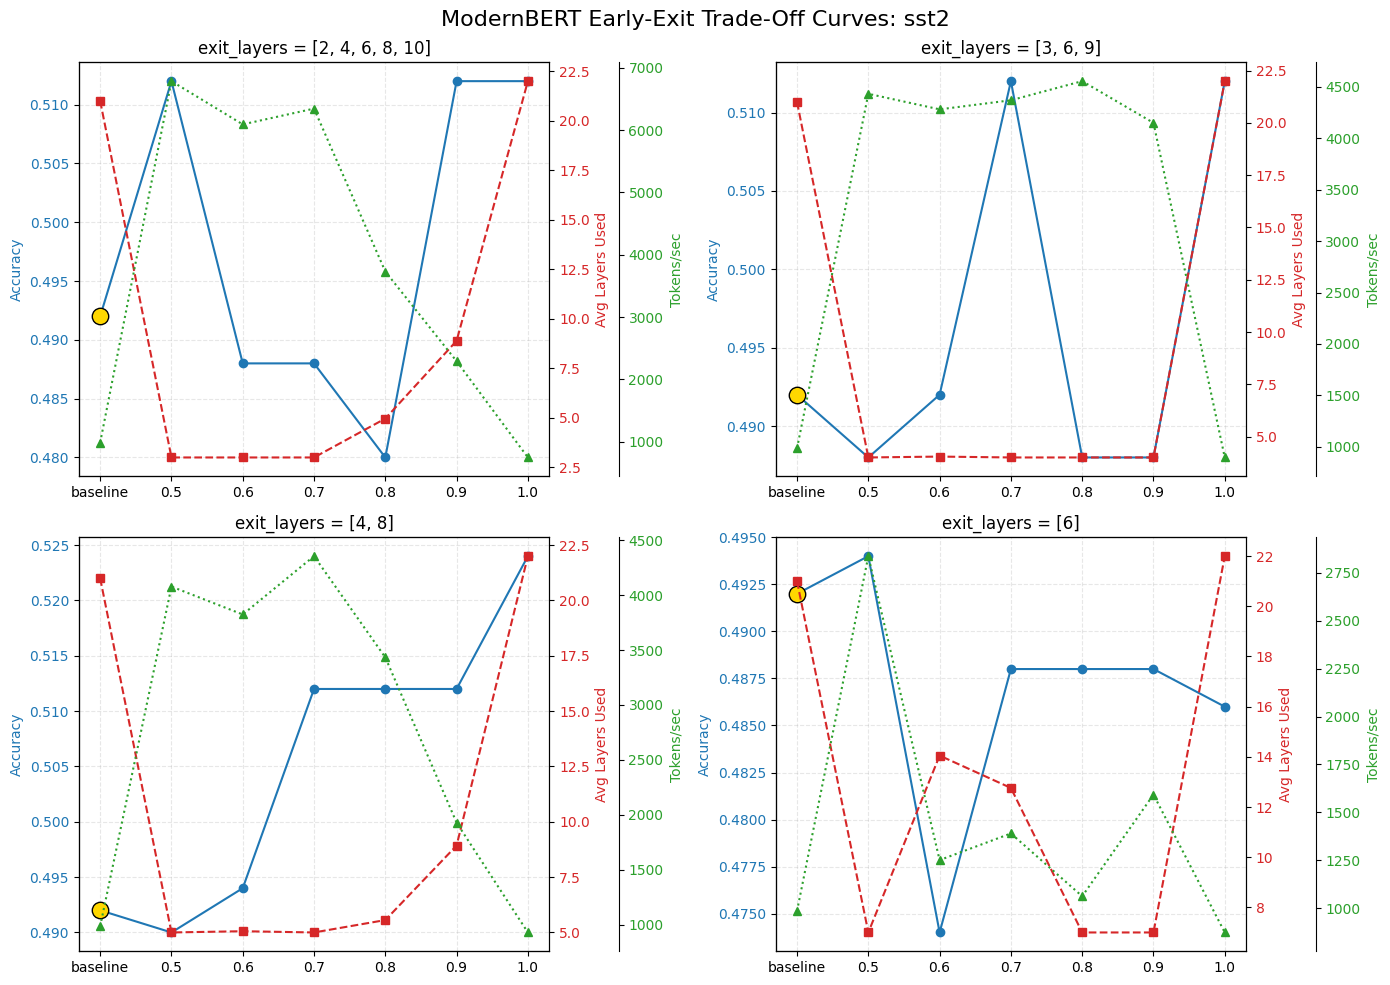

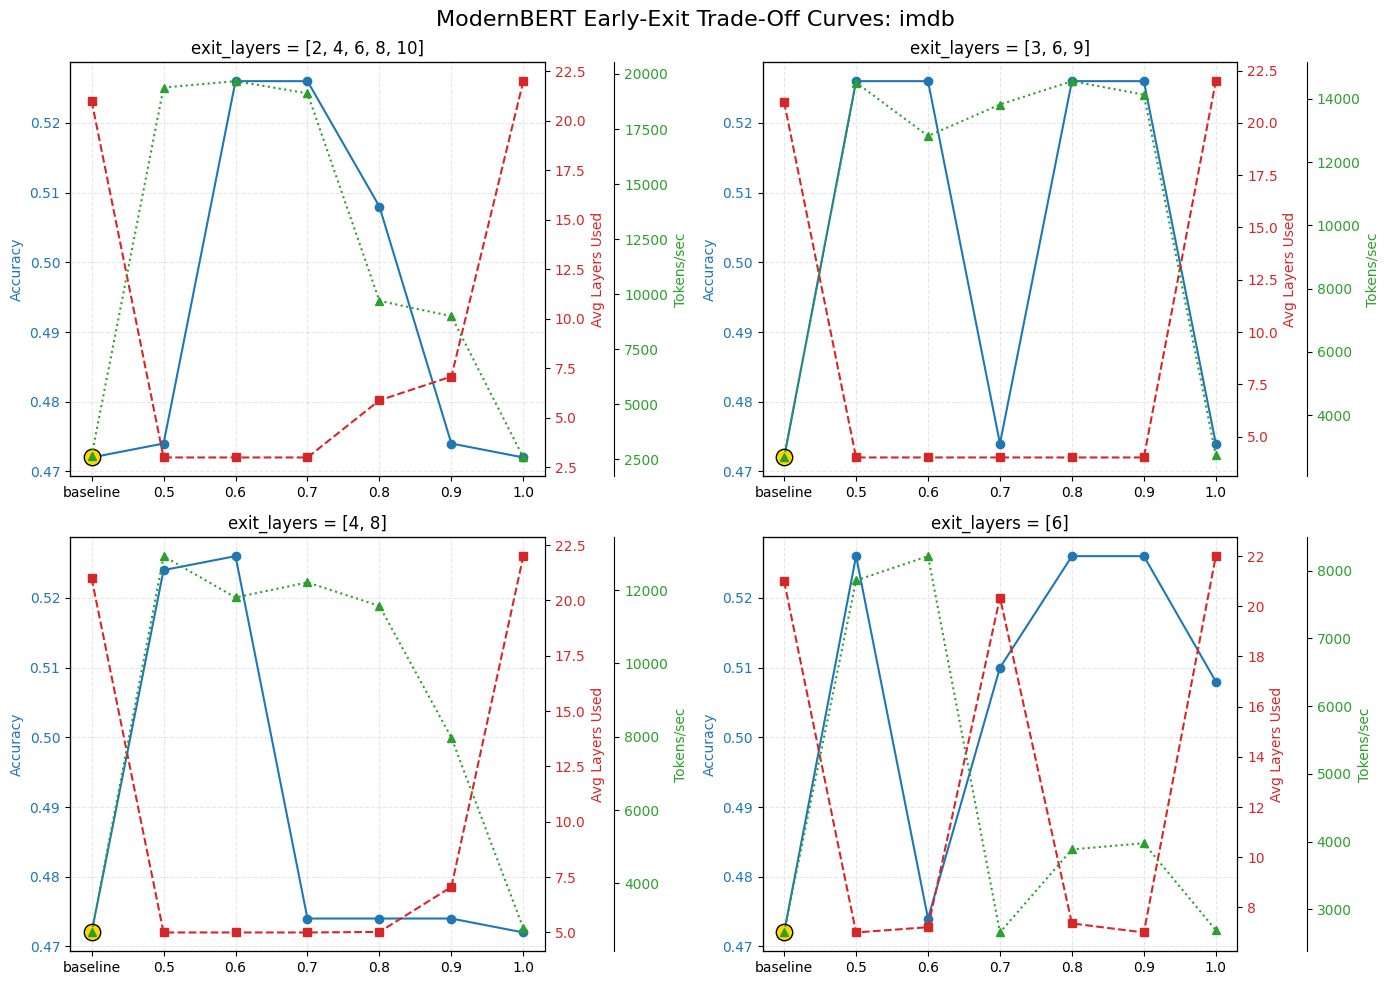

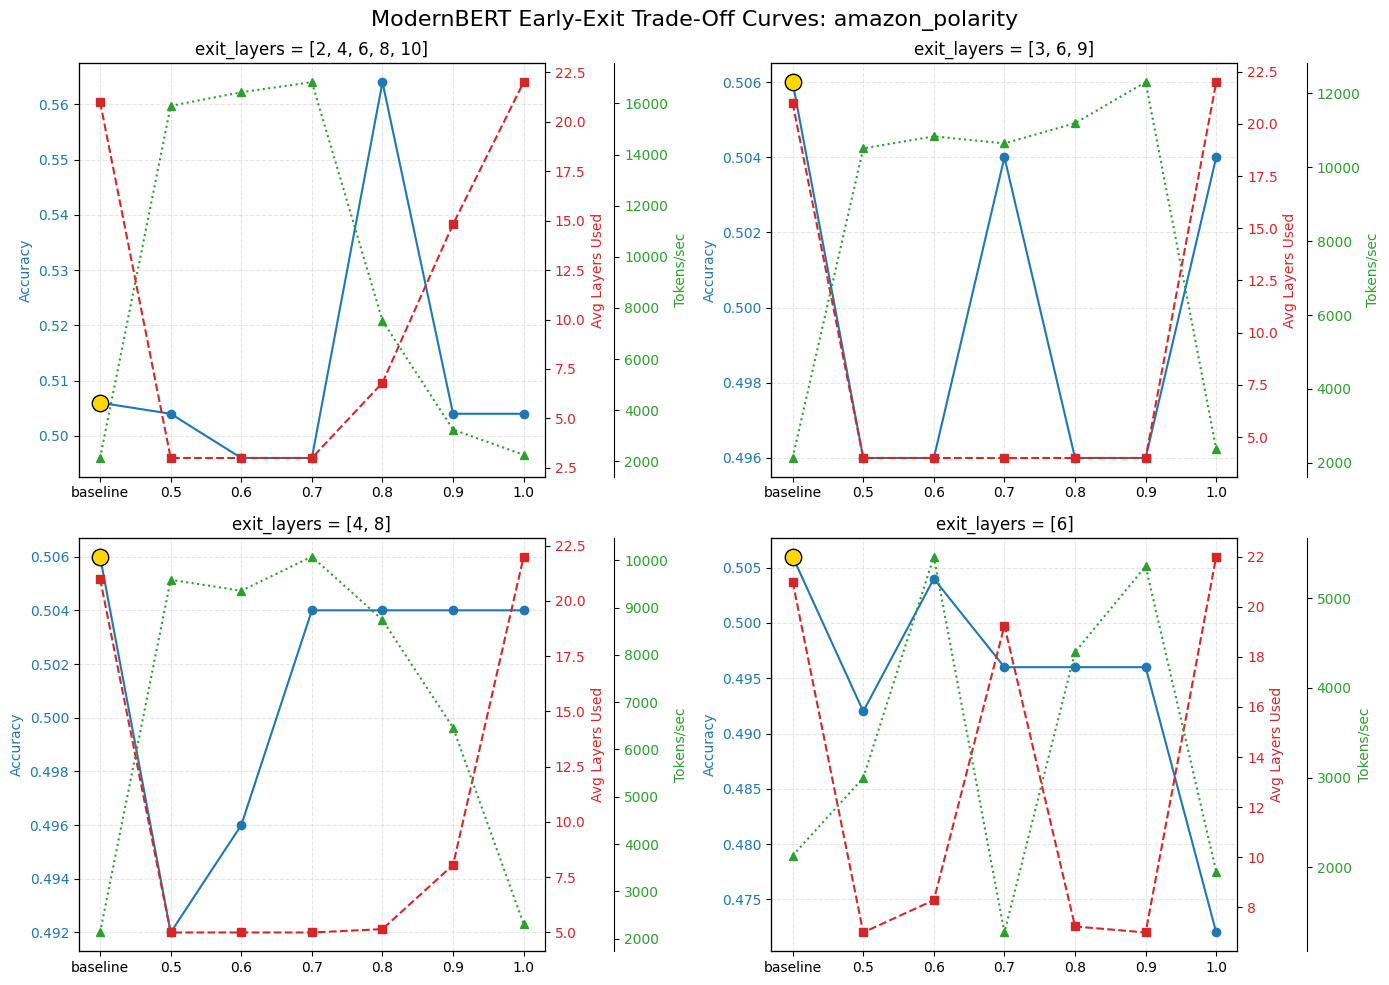

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

df2 = df.copy()

# Replace NaN thresholds with 'baseline'
df2['threshold'] = df2['threshold'].apply(
    lambda x: "baseline" if pd.isna(x) else x
)

# Convert exit_layers list → string for grouping
df2['exit_layers_str'] = df2['exit_layers'].apply(lambda x: str(x))

datasets = df2['dataset'].unique()

for ds in datasets:

    df_ds = df2[df2['dataset'] == ds]

    # Get all exit_layers configs EXCEPT baseline
    exit_configs = sorted(df_ds['exit_layers_str'].unique())
    exit_configs = [cfg for cfg in exit_configs if cfg != "nan"]

    # Only keep configs that are real lists (not baseline)
    # ensure exactly 4 for plotting (or fewer → still works)
    exit_configs = exit_configs[:4]

    # Prepare 2×2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    # Extract baseline row(s)
    df_base = df_ds[df_ds['mode'] == "baseline"]

    # ---------- LOOP OVER EXIT CONFIGS ----------
    for idx, exit_cfg in enumerate(exit_configs):

        ax = axes[idx]

        # Subset for this exit layers
        df_sub = df_ds[df_ds['exit_layers_str'] == exit_cfg]

        ###########################################
        # 1) Extract values (early-exit run)
        ###########################################
        # Early exit values
        thresholds = df_sub['threshold'].tolist()
        scores     = df_sub['score'].tolist()
        layers     = df_sub['avg_layers_used'].tolist()
        tps        = df_sub['tokens_per_sec'].tolist()
        
        # Add baseline explicitly (first element)
        if not df_base.empty:
            thresholds = ["baseline"] + thresholds
            scores     = [df_base['score'].iloc[0]] + scores
            layers     = [df_base['avg_layers_used'].iloc[0]] + layers
            tps        = [df_base['tokens_per_sec'].iloc[0]] + tps


        ###########################################
        # 2) Extract baseline values
        ###########################################
        base_thresholds = df_base['threshold'].tolist()
        base_scores     = df_base['score'].tolist()
        base_layers     = df_base['avg_layers_used'].tolist()
        base_tps        = df_base['tokens_per_sec'].tolist()

        # ---- Sorting helper: baseline always first ----
        def sort_key(x):
            return -1 if x == "baseline" else float(x)

        sorted_idx = sorted(
            range(len(thresholds)),
            key=lambda i: sort_key(thresholds[i])
        )

        thresholds = [thresholds[i] for i in sorted_idx]
        scores     = [scores[i]     for i in sorted_idx]
        layers     = [layers[i]     for i in sorted_idx]
        tps        = [tps[i]        for i in sorted_idx]

        x_pos = np.arange(len(thresholds))

        ################################################
        # ---- PLOTS (same style as your original) ----
        ################################################
        ax1 = ax

        # Accuracy curve
        ax1.plot(x_pos, scores, marker="o", color="tab:blue", label="Accuracy")
        ax1.set_ylabel("Accuracy", color="tab:blue")
        ax1.tick_params(axis="y", labelcolor="tab:blue")

        # Plot baseline point in gold
        for i, th in enumerate(thresholds):
            if th == "baseline":
                ax1.scatter(
                    x_pos[i], scores[i],
                    color="gold", s=140, edgecolor="black", zorder=6,
                    label="Baseline"
                )

        # Avg layers
        ax2 = ax1.twinx()
        ax2.plot(
            x_pos, layers,
            marker="s", linestyle="--",
            color="tab:red", label="Layers Used"
        )
        ax2.set_ylabel("Avg Layers Used", color="tab:red")
        ax2.tick_params(axis="y", labelcolor="tab:red")

        # Tokens/sec
        ax3 = ax1.twinx()
        ax3.spines["right"].set_position(("outward", 50))
        ax3.plot(
            x_pos, tps,
            marker="^", linestyle=":",
            color="tab:green", label="Tokens/sec"
        )
        ax3.set_ylabel("Tokens/sec", color="tab:green")
        ax3.tick_params(axis="y", labelcolor="tab:green")

        ax.set_xticks(x_pos)
        ax.set_xticklabels(thresholds)
        ax.set_title(f"exit_layers = {exit_cfg}")

        ax.grid(True, linestyle="--", alpha=0.3)

    # ------- FIGURE TITLE -------
    fig.suptitle(f"ModernBERT Early-Exit Trade-Off Curves: {ds}", fontsize=16)
    plt.tight_layout()
    plt.show()
